In [13]:
import pandas as pd
import numpy as np
import preprocessing as pp
import formatPredictions as fp
import datasets as datasets

#Importacion xgboost
import xgboost as xgb

#Importacion preprocesamiento
from sklearn.model_selection import train_test_split

#Importacion metricas
import metrics as m
from sklearn.metrics import roc_auc_score

#Librerias para visualizacion
import seaborn as sb
import matplotlib.pyplot as plt

plt.style.use('default')

In [4]:
df = datasets.getDataTrain()
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


In [5]:
df_edit = pd.DataFrame()
df_edit = df.copy()

X, y, df_new, y_encoder = pp.feature_engineering_xg_rf(df_edit)
df_new.head()

,tiene_alto_valor_adquisitivo,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [6]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [7]:
#Instancio el xgboost
xg_reg = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.35, learning_rate = 0.5, 
                          max_depth = 10, alpha = 5, n_estimators = 60)

In [8]:
#Entreno
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.35, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=60,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [9]:
#prediccion
preds = xg_reg.predict(X_test)

In [10]:
int_predictions = pp.get_int_predictions(preds)

Accuracy: 0.8323353293413174

Precision: 0.7673160173160173

Recall: 0.9563628983154049

F1 Score: 0.5649402390438247

Matriz de confusion: 
[[4712  215]
 [ 877  709]]

AUC-ROC: 



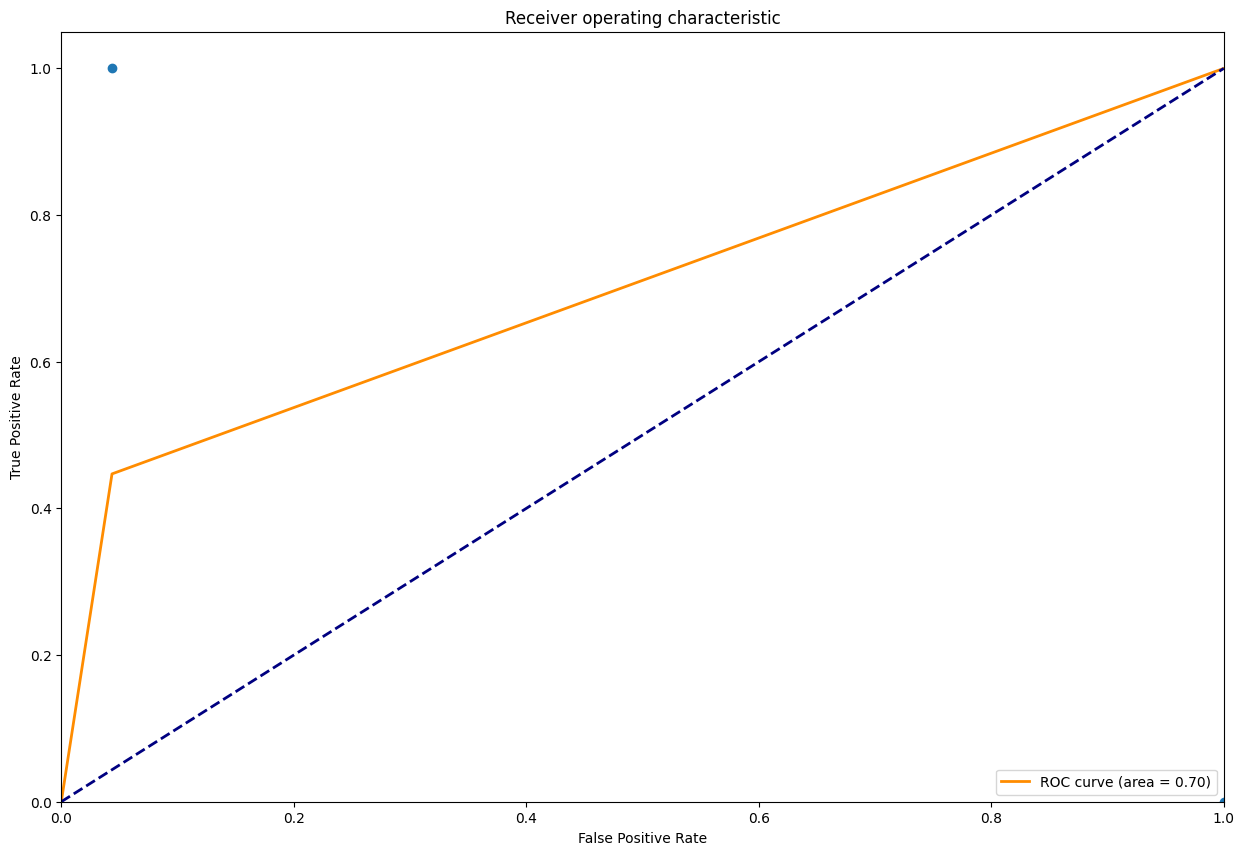

0.7016997341513973

In [12]:
# Obtener metricas
m.getMetrics(y_test, int_predictions)

In [14]:
#Porcentaje de acierto de las predicciones
print("AUC: %f" % (roc_auc_score(y_test, preds)))

AUC: 0.884174


Prediccion basada en las columnas que random forest considera como las mas importantes

In [ ]:
#Instancio el xgboost
xg_reg_rf = xgb.XGBRegressor(objective ='binary:logistic', colsample_bytree = 0.35, learning_rate = 0.13, 
                          max_depth = 3, alpha = 5, n_estimators = 60)

In [ ]:
#Extraigo las columnas que random forest considera las mas importantes para predecir

trainDf_with_random_forest_rows = pp.get_columns_by_index(X_train, [0, 1, 2, 21, 22, 26, 32, 33, 38])
testDf_with_random_forest_rows = pp.get_columns_by_index(X_test, [0, 1, 2, 21, 22, 26, 32, 33, 38])

In [ ]:
#Entreno con los datos que me dio random forest
xg_reg_rf.fit(trainDf_with_random_forest_rows,y_train)

#Predigo
preds_using_random_forest_rows = xg_reg_rf.predict(testDf_with_random_forest_rows)

In [ ]:
#Porcentaje de acierto de las predicciones
print("AUC: %f" % (roc_auc_score(y_test, preds_using_random_forest_rows)))

AUC: 0.864561


In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.35,
          'learning_rate': 0.13, 'max_depth': 5, 'alpha': 5, 'silent':1}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=60, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
cv_results.iloc[-1]['test-auc-mean']

0.8812865999999999

# Analisis de features de XGBoost

Importancia de cada feature

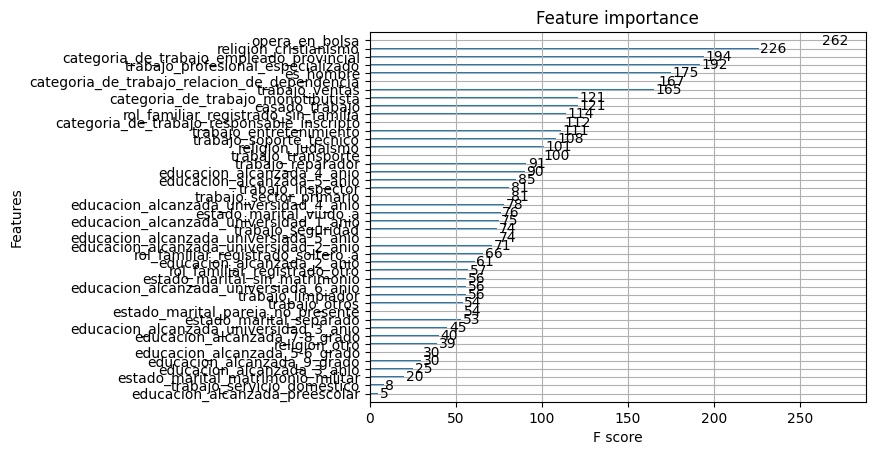

In [ ]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

Cross Validation


In [ ]:
params = {"objective":"reg:linear",'colsample_bytree': 0.35,
          'learning_rate': 0.13, 'max_depth': 5, 'alpha': 10, 'silent': 1}

cv_scores = []

for n in range(10, 100, 5):
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=n, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

In [ ]:
cv_scores

[0.8571759999999999,
 0.8670106000000001,
 0.8700927999999999,
 0.8725776,
 0.8740824,
 0.8750474,
 0.8764264,
 0.8773707999999999,
 0.8785574,
 0.8794676000000001,
 0.8800435999999999,
 0.8805755999999999,
 0.8810103999999999,
 0.8813268000000001,
 0.8816067999999999,
 0.8819088,
 0.8820642,
 0.8823038000000001]

ValueError: ignored

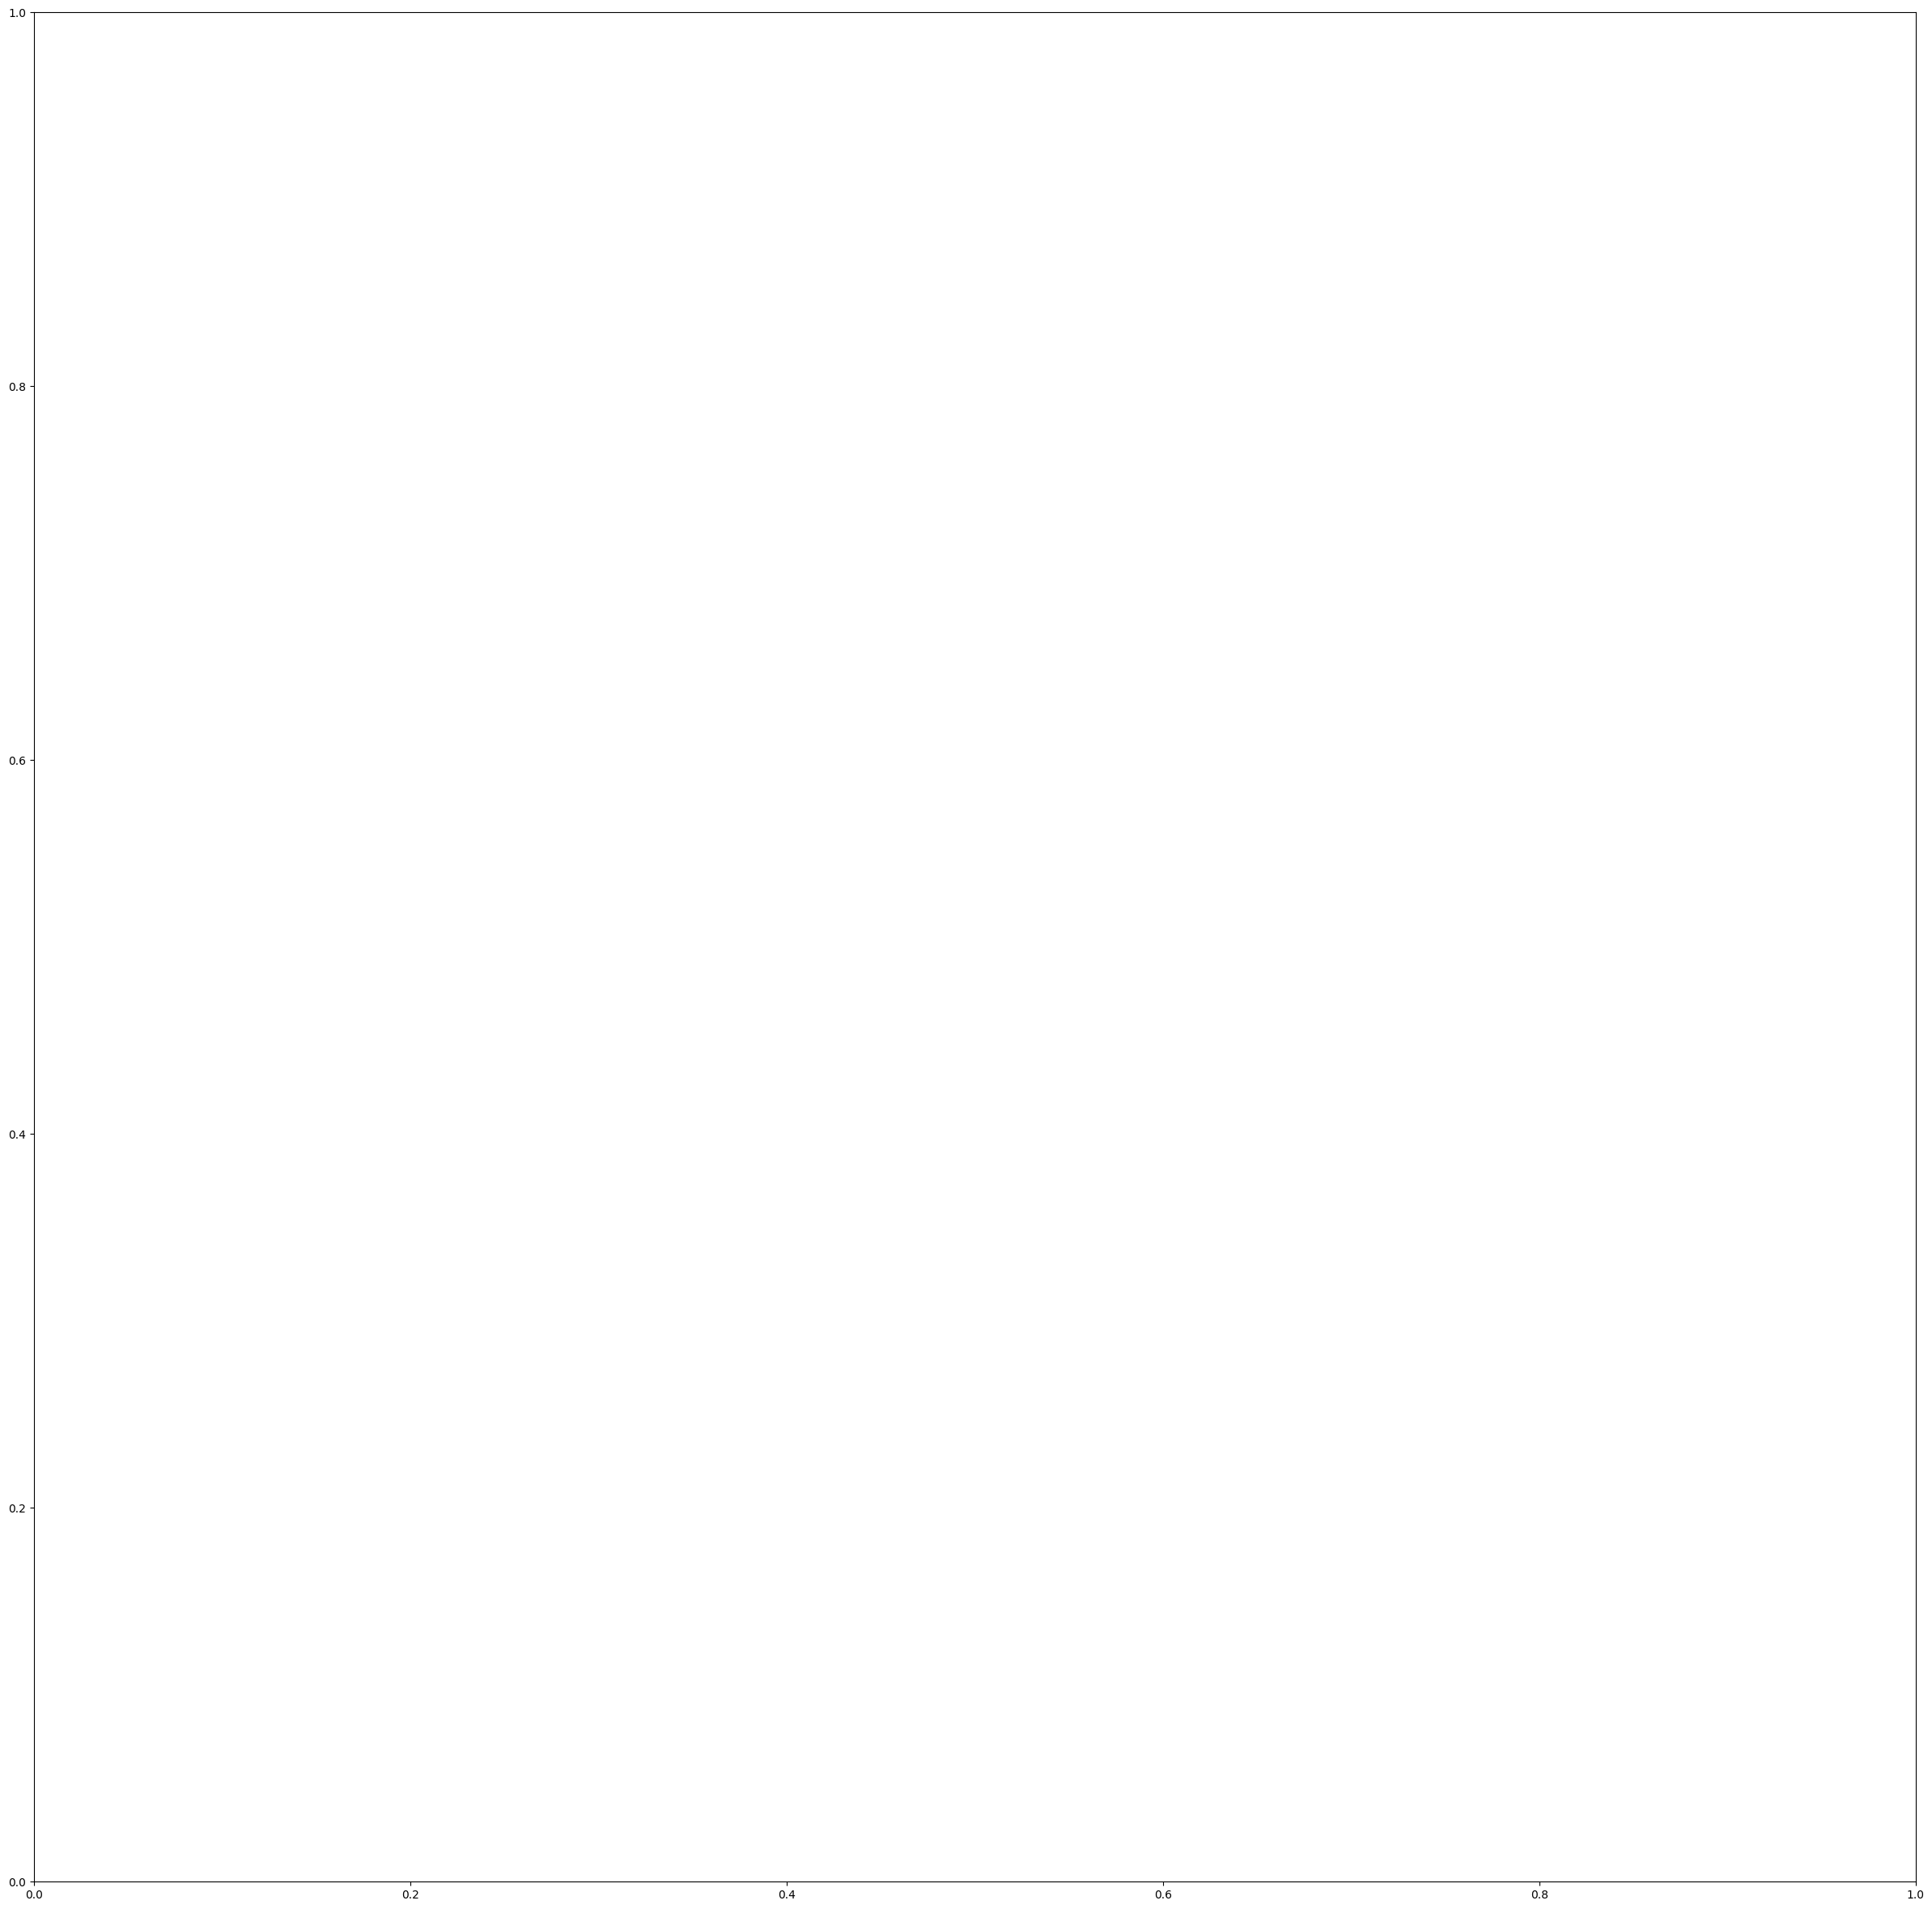

In [ ]:
abscisa=range(10, 10, 5)
plt.plot(abscisa, cv_scores)
plt.grid()
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.show()

Learning rate

In [ ]:
cv_scores = []

for n in range(1, 11):
    eta=n*0.05
    params = {"objective":"reg:linear",'colsample_bytree': 0.3,
          'learning_rate': eta, 'max_depth': 5, 'alpha': 10, 'silent': 1}
    print(eta)
    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

In [ ]:
plt.plot([x * 0.05 for x in range(1, 11)], cv_scores)
plt.grid()
plt.xlabel('eta')
plt.ylabel('Score')
plt.show()

Max_depth

In [ ]:
cv_scores = []

for n in range(1, 11):
    params = {"objective":"reg:linear",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': n, 'alpha': 10, 'silent': 1}

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

In [ ]:
plt.plot([x for x in range(1, 11)], cv_scores)
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.show()

colsample_bytree (Valor muy alto: overfitting)

In [ ]:
cv_scores = []

for n in range(1, 16):
    cst=n*0.05
    params = {"objective":"reg:linear",'colsample_bytree': cst,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': 10, 'silent': 1}

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

In [ ]:
plt.plot([x*0.05 for x in range(1, 16)], cv_scores)
plt.grid()
plt.xlabel('colsample_bytree')
plt.ylabel('Score')
plt.show()

Alpha

In [ ]:
cv_scores = []

for n in range(1, 16):
    params = {"objective":"reg:linear",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 5, 'alpha': n, 'silent': 1}

    cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=50, early_stopping_rounds=10,
                    metrics="auc", as_pandas=True, seed=123);
    cv_scores.append(cv_results.iloc[-1]['test-auc-mean'])

In [ ]:
plt.plot([x for x in range(1, 16)], cv_scores)
plt.grid()
plt.xlabel('alpha')
plt.ylabel('Score')
plt.show()

# Prediccion sobre el archivo final

In [15]:
data_test_final = datasets.getDataValidation()
data_test_final.drop(columns = ["representatividad_poblacional"], inplace=True)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina': 'ganancia_perdida_declarada_bolsa_argentina'}, inplace=True)
data_test_final.head()

,id,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,trabajo
0,1,11,Palermo,relacion_de_dependencia,25,2_anio,sin_matrimonio,0,hombre,40,judaismo,con_hijos,inspector
1,2,13,Palermo,relacion_de_dependencia,38,4_anio,matrimonio_civil,0,hombre,50,cristianismo,casado,sector_primario
2,3,16,Palermo,empleado_municipal,28,universidad_2_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,seguridad
3,4,14,Palermo,relacion_de_dependencia,44,5_anio,matrimonio_civil,7688,hombre,40,judaismo,casado,inspector
4,5,14,Palermo,NaN,18,5_anio,sin_matrimonio,0,mujer,30,cristianismo,con_hijos,NaN


In [16]:
df_test_final = pp.feature_engineering_xg_rf(data_test_final)
df_test_final.head()

,id,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#prediccion
predictions_final = xg_reg.predict(df_test_final.iloc[:, 1:47])

In [ ]:
#Exporto las predicciones
fp.exportPredictions(fp.formatPredictions(predictions_final), "predictions_final_xgboost")